- In an election, two candidates, Albert and Benjamin, have in a ballot box $a$ and $b$ votes respectively with $a>b$
- Ballots are randomly drawn and tallied
- *What is the chance that at least once after the first tally, the candidates have the same number of tallies?*

____

- First, before we start solving this problem, let's simulate this process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = 10, 10

In [262]:
list_final_results = []
n_trials = 10000

for a in range(2, 100):
    for b in range(1, a):
        count = 0
        array_votes = np.repeat(np.array(a*[1]+b*[-1])[:,np.newaxis], n_trials, axis=1)
        idx_random = np.random.rand(*array_votes.shape).argsort(0)
        array_votes_shuffled = array_votes[idx_random, np.arange(array_votes.shape[1])]
        array_tally = np.cumsum(array_votes_shuffled, axis=0)
        array_ties = (np.amin(array_tally, axis=0)<=0).astype(int)
        list_final_results.append((a, b, np.mean(array_ties)))

In [263]:
x = [a for a, b, c in list_final_results]
y = [b for a, b, c in list_final_results]
color = [c for a, b, c in list_final_results]

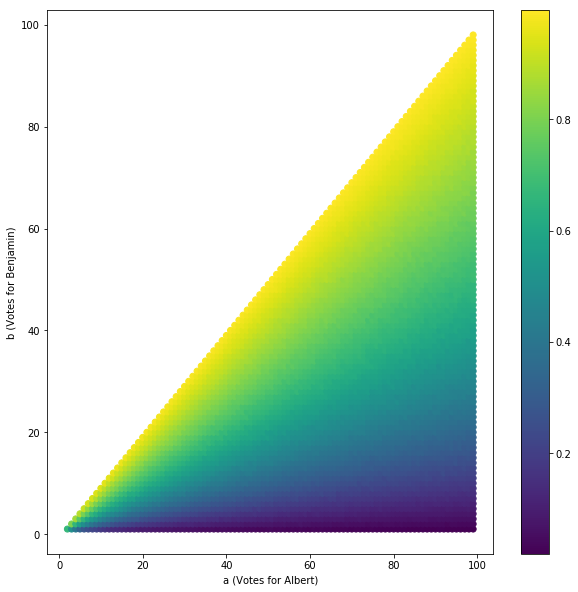

In [264]:
plt.scatter(x, y, c=color)
plt.colorbar()
plt.xlabel('a (Votes for Albert)')
plt.ylabel('b (Votes for Benjamin)')
plt.show()

In [265]:
df_summary = pd.DataFrame({'a':x, 'b':y, 'P':color}).pivot(index='a', columns='b',values='P')

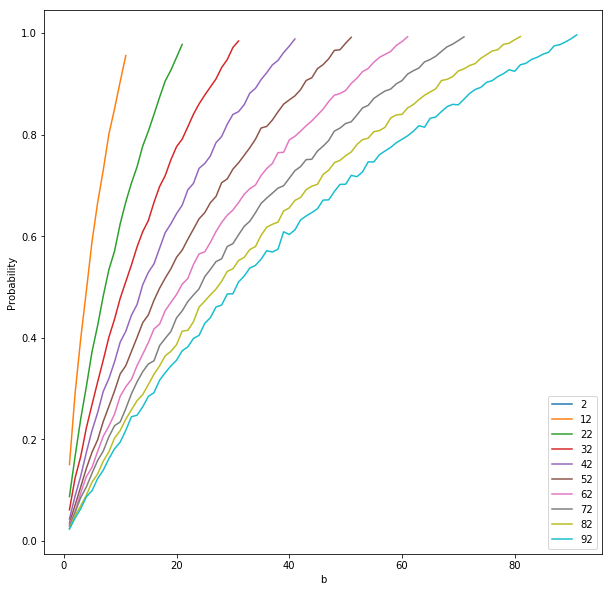

In [266]:
df_summary_sample = df_summary.iloc[::10].T
df_summary_sample.plot()
plt.ylabel('Probability')
plt.legend(loc='lower right')
plt.show()

- As we can see from the plot, **the closer a and b are, the higher the probability that the tallies will be equal at some point in the counting**

_____

- To get to the solution, let's start with a simple case
    - $a=2, b=1$
    
- So, there are 3 ways the votes can be tallied
    1. [A, A, B]
    2. [A, B, A]
    3. [B, A, A]
    
- In scenario 1, they never have the same number of votes
    - In scenarios 2 and 3, there are moments where they are tied in votes
    
- **Therefore, the probability that their tallies will be equal is 2/3**

- We understand that any path that leads to a tie has the same number of votes for each candidate
    - E.g. Assume our order was [A,A,B,A,B,B]
        - 3 As and 3 Bs
    - **We note that if we replace each B with an A, and each A with a B, we'll still have 3 As and 3 Bs, so this is essentially the complementary tie of this order**
        - Since we can do this for every ordering of tallies that leads to a tie, **each tie has a "sister tie" which is the mirror image**

- As an example, consider the tallies above
    - The first two votes for scenario 2 are A and B
    - The first two votes for scenario 3 are B and A
        - They both lead to a tie, and they're "sisters"

- So let's think of each example as a **set of paths**
    - Each path represents a way the votes can me tallied
        - If we consider a vote for Benjamin to be -1 and a vote for Albert to be +1, then a tie occurs when the cumulative sum of the path's steps is equal to zero

- Let's look at a couple charts to think about this

In [283]:
from scipy.special import comb
from itertools import combinations

In [296]:
a = 4
b = 3

n_votes = a + b
n_paths = int(comb(n_votes, b))
df_paths = pd.DataFrame(0, index = range(n_votes+1), columns = range(n_paths))

df_paths.loc[1:] = 1

for i, choices in enumerate(combinations(range(1, n_votes+1), b)):
    df_paths.loc[choices, i] = -1
    
df_paths = df_paths.cumsum()

In [297]:
df_paths

0   1   2   3   4   5   6   7   8   9  ...  25  26  27  28  29  30  31  32  \
0   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   
1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 ...   1   1   1   1   1   1   1   1   
2  -2  -2  -2  -2  -2   0   0   0   0   0 ...   2   2   2   2   2   2   2   2   
3  -3  -1  -1  -1  -1  -1  -1  -1  -1   1 ...   1   1   1   1   1   1   3   3   
4  -2  -2   0   0   0  -2   0   0   0   0 ...   0   0   0   2   2   2   2   2   
5  -1  -1  -1   1   1  -1  -1   1   1  -1 ...  -1   1   1   1   1   3   1   1   
6   0   0   0   0   2   0   0   0   2   0 ...   0   0   2   0   2   2   0   2   
7   1   1   1   1   1   1   1   1   1   1 ...   1   1   1   1   1   1   1   1   

   33  34  
0   0   0  
1   1   1  
2   2   2  
3   3   3  
4   2   4  
5   3   3  
6   2   2  
7   1   1  

[8 rows x 35 columns]

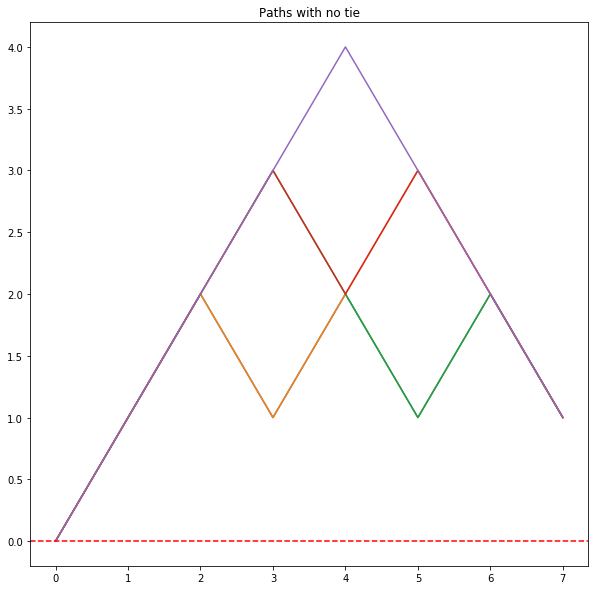

In [305]:
df_paths[[x for x in df_paths.columns if df_paths.loc[1:,x].min()>0]].plot(legend=False)
plt.title('Paths with no tie')
plt.axhline(0, ls='dashed', c='r')
plt.show()

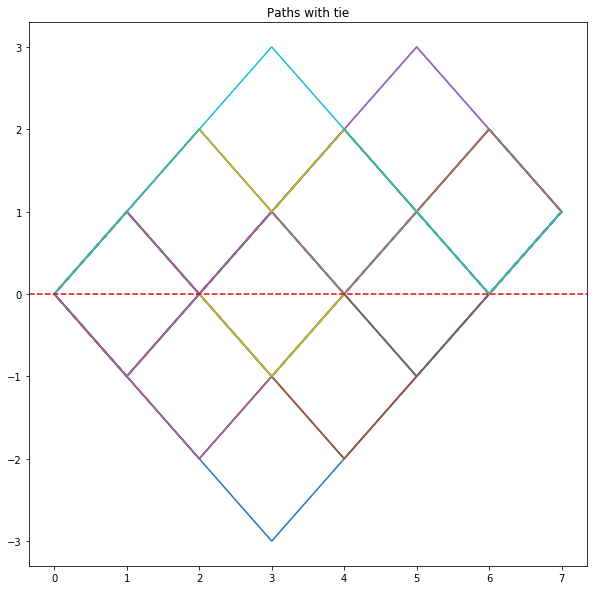

In [306]:
df_paths[[x for x in df_paths.columns if df_paths.loc[1:,x].min()<=0]].plot(legend=False)
plt.title('Paths with tie')
plt.axhline(0, ls='dashed', c='r')
plt.show()

- As we already discussed, each path that leads to a tie has a "sister path" that is its mirror image across the dotted red line

- If the first vote goes to Benjamin, we know the tallies need to be equal at some point since Albert has more
    - So each path that steps down first results in a tie
        - Therefore, **each path that steps up first that eventually results in a tie has a sister path that starts with a step down**
            - **THEREFORE, THE PROBABILITY THAT THE TALLIES ARE EVENTUALLY TIED IS EQUAL TO TWICE THE PROBABILITY THAT THE FIRST STEP IS DOWNWARDS**

$$
P(\text{Eventually tied}) = 2\cdot P(\text{First vote goes to Benjamin}) = 2\cdot\frac{b}{a+b}
$$

- Let's compare these results to our curves above

In [317]:
a_array = np.array(df_summary_sample_comparison.columns)
b_array = np.array(df_summary_sample_comparison.index)[:,np.newaxis]
a_plus_b_array = a_array + b_array
probability_array = 2*b_array/a_plus_b_array

In [320]:
df_summary_sample_comparison = (pd.notnull(df_summary_sample).astype(int)*probability_array).replace(0, np.nan)

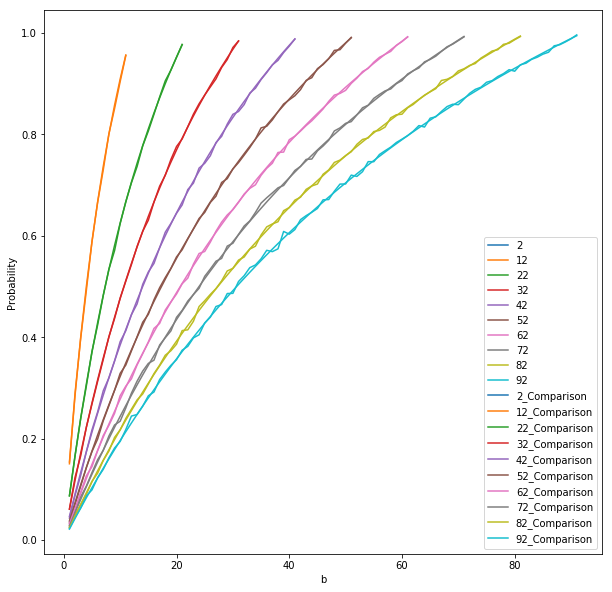

In [328]:
df_summary_sample = df_summary.iloc[::10].T
df_summary_sample.join(df_summary_sample_comparison, rsuffix='_Comparison').plot()
#df_summary_sample_comparison.plot(ls='dashed')
plt.ylabel('Probability')
plt.legend(loc='lower right')
plt.show()

- Bang on